### Model VGG16



In [2]:
import pickle
from tensorflow.keras.utils import to_categorical
import pandas as pd
from keras.callbacks import Callback, EarlyStopping ,ModelCheckpoint 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.preprocessing import image
from livelossplot import PlotLossesKeras 
import cv2
import numpy as np
np.random.seed(0)




In [3]:
data_dir = r"C:\Base_Camp\Pliki\archive"
train_dir = r"C:\Base_Camp\Pliki\archive\train"
test_dir = r"C:\Base_Camp\Pliki\archive\test"
datagen = ImageDataGenerator(rescale = 1.0/255.0, validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Number of classes: 7


In [4]:
print(f"Train class indices: {train_generator.class_indices}")
print(f"Validation class indices: {validation_generator.class_indices}")

Train class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Validation class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [5]:
base_model = VGG16(weights='imagenet', include_top=False,input_shape = (48, 48,3) )

In [18]:
for layer in base_model.layers[1:]:
    layer.trainable = False

num_layers_to_unfreeze = 4  # liczba warstw do odmrożenia
conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]


model = Sequential([
    base_model,
    
    Flatten(), 
        
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(7 , activation='softmax')
    
])

optimizer = Adam(0.001, decay=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


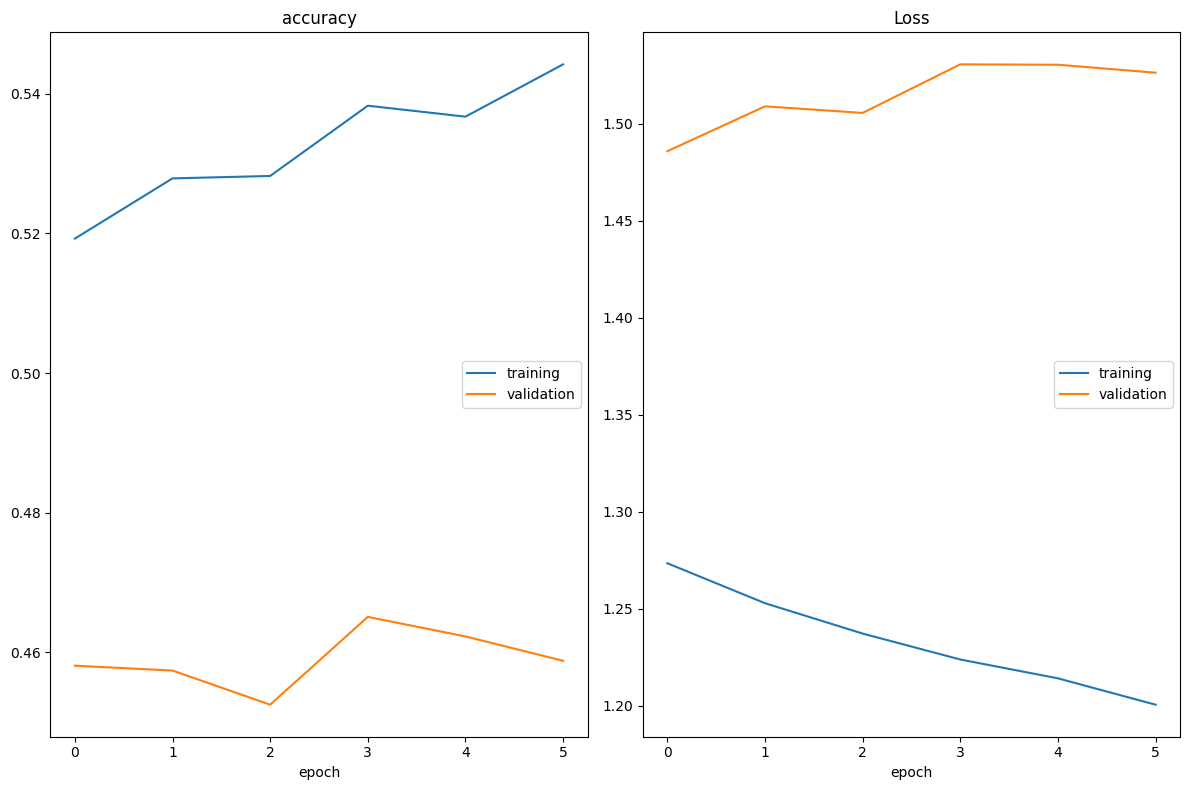

accuracy
	training         	 (min:    0.519, max:    0.544, cur:    0.544)
	validation       	 (min:    0.453, max:    0.465, cur:    0.459)
Loss
	training         	 (min:    1.200, max:    1.273, cur:    1.200)
	validation       	 (min:    1.486, max:    1.531, cur:    1.526)

Epoch 6: val_loss did not improve from 1.48591
718/718 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.5487 - loss: 1.1870 - val_accuracy: 0.4588 - val_loss: 1.5264
Epoch 6: early stopping


In [24]:
callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath= 'C:\Base_Camp\Pliki\models\emotion_model_VGG16_model_{epoch:02d}_{val_loss:.2f}.keras', 
                    monitor='val_loss', save_best_only=True, mode='min' , verbose=1)
]

history = model.fit(
        train_generator,
        epochs=50,
        callbacks=callbacks,
        validation_data=validation_generator
    )

In [18]:
model.save(r'C:\Base_Camp\Pliki\emotion_model_VGG16.h5')

In [26]:


emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(face_image, model):
    face_image = cv2.resize(face_image, (48, 48))
    face_image = cv2.cvtColor(face_image, cv2.COLOR_GRAY2RGB)  
    face_image = face_image / 255.0
    face_image = np.expand_dims(face_image, 0) 
    predictions = model.predict(face_image)
    return emotion_labels[np.argmax(predictions)]

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        emotion = predict_emotion(face, model)
        
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Emotion Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
